# 시계열 분석 연습문제

## 문제1

## #01. 작업준비

### 필요한 패키지 설치

In [1]:
import sys
sys.path.append("../../")

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA 
from pmdarima.arima import auto_arima
import seaborn as sb
from statsmodels.tsa.stattools import adfuller

from helper import set_datetime_index, exp_time_data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 데이터 가져오기

In [2]:
df = read_excel("https://data.hossam.kr/E06/temperatures_seoul.xlsx")
df

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9
...,...,...
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3


## #02. 데이터 정제

### 각 필드의 데이터타입 확인

In [3]:
df.dtypes

날짜         datetime64[ns]
평균기온(℃)           float64
dtype: object

### 결측치 검사

In [4]:
df.isna().sum()

날짜         0
평균기온(℃)    0
dtype: int64

### date 필드를 날짜 형식의 인덱스로 지정

In [5]:
df2 = set_datetime_index(df, '날짜')
df2

,평균기온(℃)
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9
...,...
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0
2023-08-05,30.3


## #03. ADF 검정 (정상성 테스트)

In [11]:
# 정상성을 만족하는지 여부를 검사한다.
# 귀무가설 : 정상성을 만족시키지 않는다. / 대립가설 : 정상성을 만족시킨다.
ar = adfuller(df2['평균기온(℃)'])
ar[1]

1.5897525859411133e-25

#### p-value가 1.5897525859411133e-25이므로 유의수준보다 작기때문에 대립가설 채택
= 이 데이터는 정상성을 만족시킨다. 고로 차분 실시 X

## #04. ACF, PACF 검정 실시 (정상성 만족여부 파악 및 모델 결정)

In [9]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

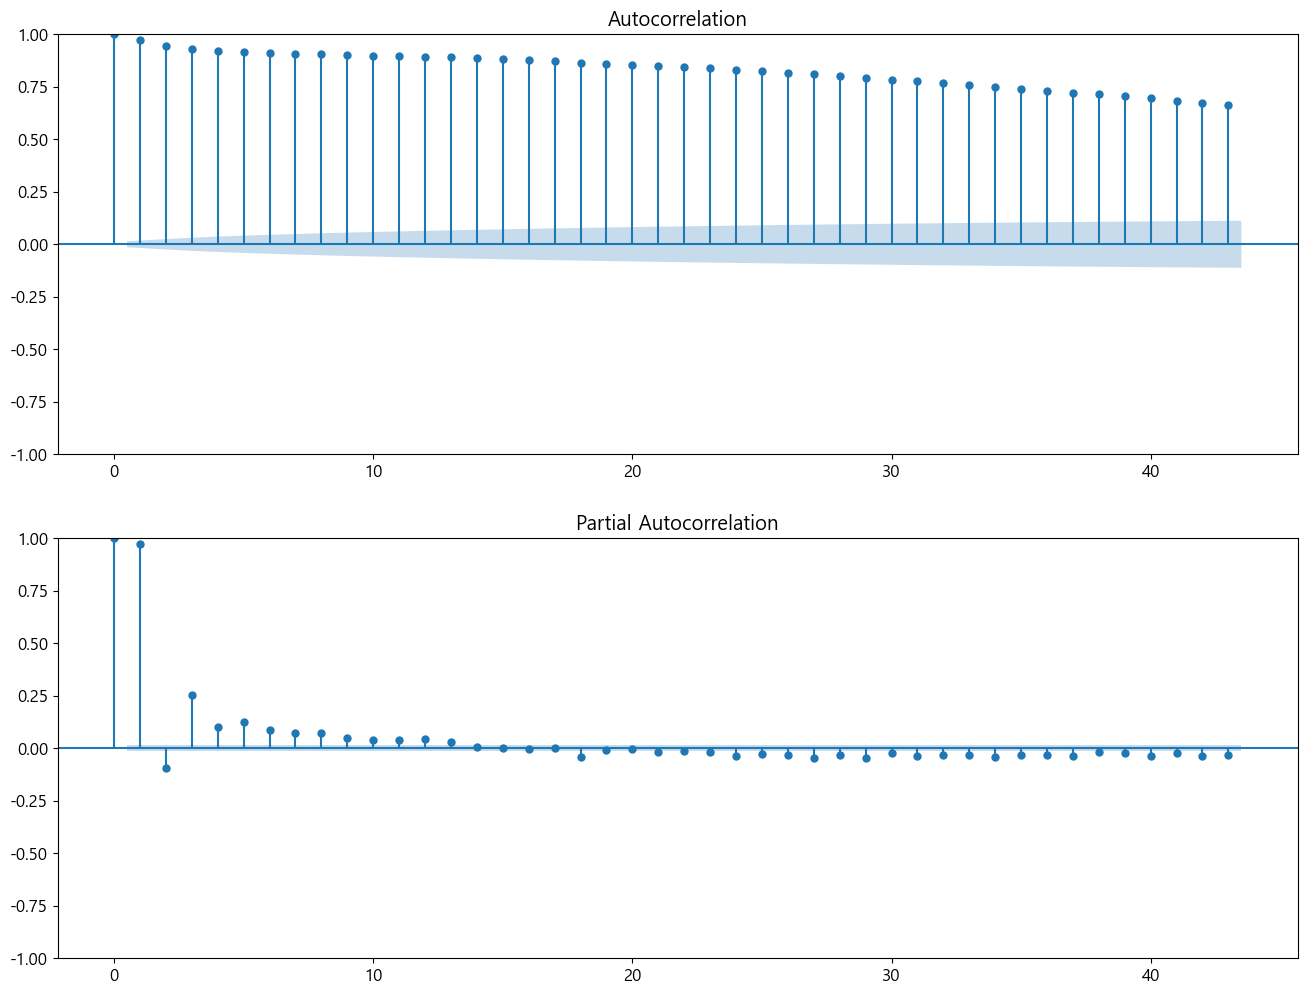

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,12))

plot_acf(df2['평균기온(℃)'], ax=ax1)
plot_pacf(df2['평균기온(℃)'], ax=ax2)
plt.show()
plt.close()

#### ACF는 0으로 수렴 X / PACF는 시차4이후 0으로 수렴

p = 4, q = 0 , d = 0

AR(4) 모델 채택!

ARIMA(4,0,0)

## #05. ARIMA 분석

### 분석모델 구축

In [26]:
model = ARIMA(df2['평균기온(℃)'], order=(4,0,0), seasonal_order=(4,0,0,12))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                          평균기온(℃)   No. Observations:                18299
Model:             ARIMA(4, 0, 0)x(4, 0, 0, 12)   Log Likelihood              -40682.260
Date:                          Tue, 08 Aug 2023   AIC                          81384.520
Time:                                  01:21:41   BIC                          81462.666
Sample:                              07-01-1973   HQIC                         81410.197
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6517      1.008     12.552      0.000      10.676      14.627
ar.L1          1.0642      0.006    165.527      0.

### 학습데이터에 대한 예측치

In [27]:
fv = fit.fittedvalues
fv.head()

1973-07-01    12.651650
1973-07-02    22.443010
1973-07-03    23.591647
1973-07-04    26.994478
1973-07-05    23.854829
Freq: D, dtype: float64

In [28]:
fc = fit.forecast(365)
fc.tail()

2024-08-01    12.709196
2024-08-02    12.708291
2024-08-03    12.707401
2024-08-04    12.706524
2024-08-05    12.705661
Freq: D, Name: predicted_mean, dtype: float64

### 시각화

In [81]:
last = df2.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=365+10)
ymax = df2['평균기온(℃)'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2022-08-06 00:00:00'), Timestamp('2024-08-15 00:00:00'), 30.3)

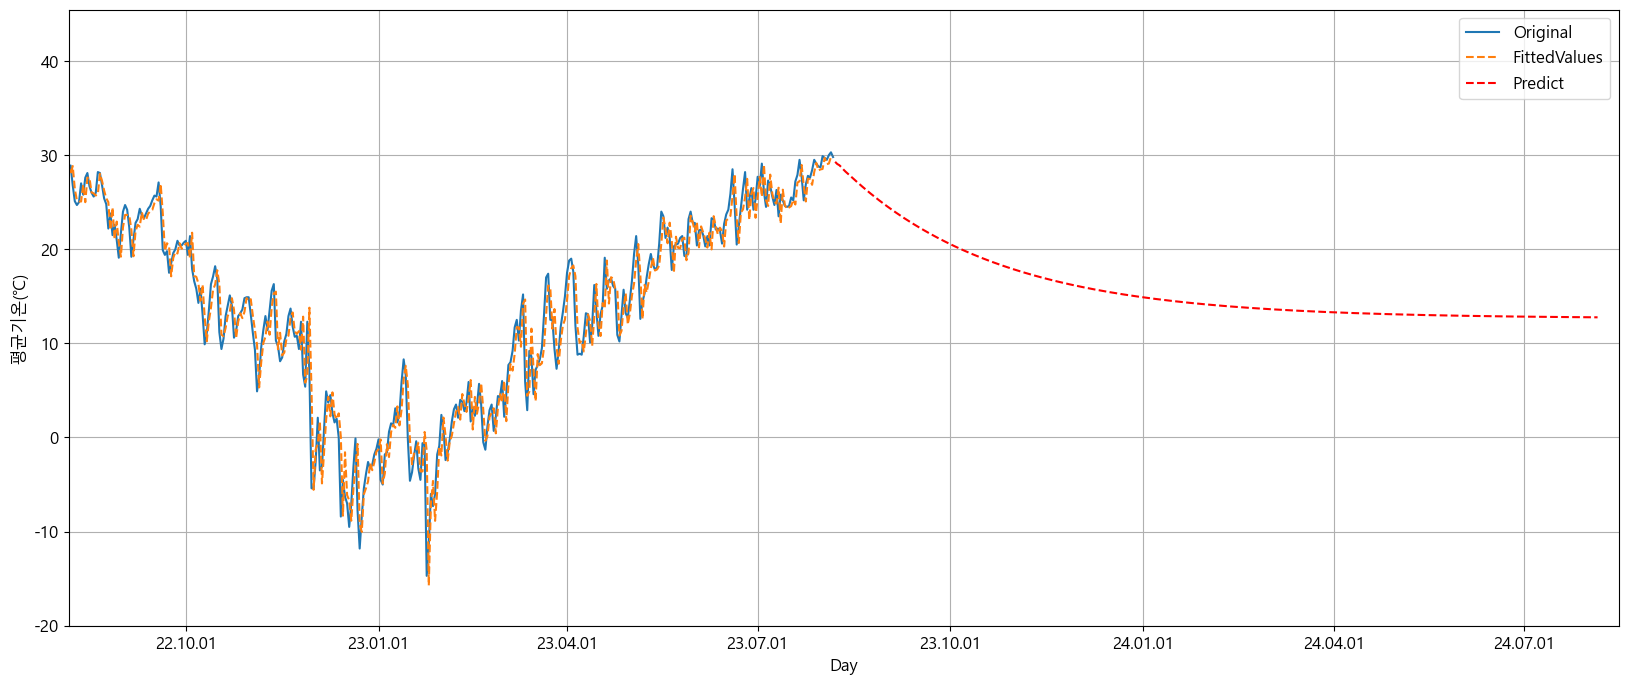

In [82]:
plt.figure(figsize=(20,8))

# 원본데이터
sb.lineplot(data=df2, x=df2.index, y='평균기온(℃)', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 365일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('평균기온(℃)')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([-20,ymax*1.5])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

### #06. AutoARIMA 분석

In [17]:
my_p = 4    # AR의 차수(검증한 결과를 활용)
my_d = 1    # 차분횟수(검증한 결과를 활용)
my_q = 0    # MA의 차수(검증한 결과를 활용)
my_s = 12    # 계절성 주기(분석가가 판단)

model = auto_arima(
    y=df2['평균기온(℃)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=97143.193, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=90787.948, Time=1.30 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=96675.126, Time=0.34 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=90992.763, Time=0.55 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=90789.948, Time=3.24 sec

Best model:  ARIMA(1,1,0)(1,1,0)[4]          
Total fit time: 5.805 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                18299
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood              -45390.974
Date:                           Tue, 08 Aug 2023   AIC                          90787.948
Time:                                   01:01:30   BIC                          90811.391
Sample:                               07-01-1973   HQIC                         90795.651
     

### 학습한 데이터와 동일 기간에 대한 예측치 산정

In [53]:
fv = model.fittedvalues()
fv

1973-07-01     0.000000
1973-07-02    22.700014
1973-07-03    23.800002
1973-07-04    27.199997
1973-07-05    36.549995
                ...    
2023-08-02    30.161578
2023-08-03    29.401091
2023-08-04    29.878964
2023-08-05    31.160759
2023-08-06    29.904508
Freq: D, Length: 18299, dtype: float64

### 향후 365일간의 예측

In [54]:
fc = model.predict(n_periods=365)
fc

2023-08-07    29.526623
2023-08-08    29.708468
2023-08-09    30.482159
2023-08-10    30.140109
2023-08-11    29.905369
                ...    
2024-08-01    52.761689
2024-08-02    53.053279
2024-08-03    53.663574
2024-08-04    53.267040
2024-08-05    53.018972
Freq: D, Length: 365, dtype: float64

### 시각화